In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "40X"
trainable_blocks = ["block3", "block4"]
irun = 4


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_40X-BREAKHIS-Dataset-60-10-30-VGGINet/4'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/40X/4'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1077 files belonging to 2 classes.


Found 179 files belonging to 2 classes.


Found 539 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2100 - accuracy: 0.4844

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 5.8785 - accuracy: 0.5820

3/9 [=========>....................] - ETA: 4s - loss: 5.5565 - accuracy: 0.6536

4/9 [============>.................] - ETA: 8s - loss: 5.1838 - accuracy: 0.6699

5/9 [===============>..............] - ETA: 7s - loss: 5.3373 - accuracy: 0.6719

6/9 [===================>..........] - ETA: 4s - loss: 5.0479 - accuracy: 0.6771

7/9 [======================>.......] - ETA: 3s - loss: 4.5861 - accuracy: 0.7054

8/9 [=========================>....] - ETA: 1s - loss: 4.2469 - accuracy: 0.7285

9/9 [==============================] - ETA: 0s - loss: 4.0886 - accuracy: 0.7344

9/9 [==============================] - 34s 4s/step - loss: 4.0886 - accuracy: 0.7344 - val_loss: 16.0888 - val_accuracy: 0.8212


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 3.6220 - accuracy: 0.8281

2/9 [=====>........................] - ETA: 13s - loss: 4.1485 - accuracy: 0.8281

3/9 [=========>....................] - ETA: 15s - loss: 3.8293 - accuracy: 0.8255

4/9 [============>.................] - ETA: 11s - loss: 3.7129 - accuracy: 0.8262

5/9 [===============>..............] - ETA: 7s - loss: 3.5426 - accuracy: 0.8219 

6/9 [===================>..........] - ETA: 5s - loss: 3.4550 - accuracy: 0.8177

7/9 [======================>.......] - ETA: 3s - loss: 3.3123 - accuracy: 0.8214

8/9 [=========================>....] - ETA: 1s - loss: 3.0509 - accuracy: 0.8281

9/9 [==============================] - ETA: 0s - loss: 2.9486 - accuracy: 0.8329

9/9 [==============================] - 16s 2s/step - loss: 2.9486 - accuracy: 0.8329 - val_loss: 6.7327 - val_accuracy: 0.8547


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7462 - accuracy: 0.8516

2/9 [=====>........................] - ETA: 13s - loss: 2.4285 - accuracy: 0.8398

3/9 [=========>....................] - ETA: 9s - loss: 2.2023 - accuracy: 0.8594 

4/9 [============>.................] - ETA: 9s - loss: 1.9871 - accuracy: 0.8730

5/9 [===============>..............] - ETA: 7s - loss: 1.9673 - accuracy: 0.8734

6/9 [===================>..........] - ETA: 4s - loss: 1.9180 - accuracy: 0.8789

7/9 [======================>.......] - ETA: 3s - loss: 1.9188 - accuracy: 0.8750

8/9 [=========================>....] - ETA: 1s - loss: 1.8993 - accuracy: 0.8711

9/9 [==============================] - ETA: 0s - loss: 1.9257 - accuracy: 0.8719

9/9 [==============================] - 16s 2s/step - loss: 1.9257 - accuracy: 0.8719 - val_loss: 6.8913 - val_accuracy: 0.8436


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1135 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 15s - loss: 0.7975 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 11s - loss: 0.9560 - accuracy: 0.9010

4/9 [============>.................] - ETA: 11s - loss: 1.2371 - accuracy: 0.8926

5/9 [===============>..............] - ETA: 7s - loss: 1.2064 - accuracy: 0.8875 

6/9 [===================>..........] - ETA: 5s - loss: 1.2509 - accuracy: 0.8919

7/9 [======================>.......] - ETA: 3s - loss: 1.1400 - accuracy: 0.8962

8/9 [=========================>....] - ETA: 1s - loss: 1.1779 - accuracy: 0.8984

9/9 [==============================] - ETA: 0s - loss: 1.2319 - accuracy: 0.8951

9/9 [==============================] - 16s 2s/step - loss: 1.2319 - accuracy: 0.8951 - val_loss: 3.8368 - val_accuracy: 0.8771


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3450 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4997 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.5975 - accuracy: 0.9427

4/9 [============>.................] - ETA: 10s - loss: 0.6652 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.7831 - accuracy: 0.9219 

6/9 [===================>..........] - ETA: 5s - loss: 0.8788 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 1.0084 - accuracy: 0.9163

8/9 [=========================>....] - ETA: 1s - loss: 0.9899 - accuracy: 0.9150

9/9 [==============================] - ETA: 0s - loss: 0.9706 - accuracy: 0.9155

9/9 [==============================] - 16s 2s/step - loss: 0.9706 - accuracy: 0.9155 - val_loss: 3.6934 - val_accuracy: 0.8715


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3168 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 1.0216 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 1.0051 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 9s - loss: 0.9517 - accuracy: 0.9180

5/9 [===============>..............] - ETA: 7s - loss: 0.8060 - accuracy: 0.9281

6/9 [===================>..........] - ETA: 4s - loss: 0.7782 - accuracy: 0.9271

7/9 [======================>.......] - ETA: 3s - loss: 0.7869 - accuracy: 0.9252

8/9 [=========================>....] - ETA: 1s - loss: 0.7443 - accuracy: 0.9229

9/9 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.9201

9/9 [==============================] - 15s 2s/step - loss: 0.7697 - accuracy: 0.9201 - val_loss: 1.5643 - val_accuracy: 0.9330


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2497 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.6088 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.7574 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 0.7079 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 0.8079 - accuracy: 0.9141

6/9 [===================>..........] - ETA: 5s - loss: 0.7960 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 0.7544 - accuracy: 0.9141

8/9 [=========================>....] - ETA: 1s - loss: 0.7712 - accuracy: 0.9131

9/9 [==============================] - ETA: 0s - loss: 0.7644 - accuracy: 0.9146

9/9 [==============================] - 16s 2s/step - loss: 0.7644 - accuracy: 0.9146 - val_loss: 1.5731 - val_accuracy: 0.9106


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7371 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 1.2745 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 1.1599 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 1.0379 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 1.0044 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.8939 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.8140 - accuracy: 0.9397

8/9 [=========================>....] - ETA: 1s - loss: 0.8359 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.9378

9/9 [==============================] - 16s 2s/step - loss: 0.8410 - accuracy: 0.9378 - val_loss: 1.6766 - val_accuracy: 0.9162


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6110 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.7378 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 10s - loss: 0.7281 - accuracy: 0.9349

4/9 [============>.................] - ETA: 11s - loss: 0.7868 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.7580 - accuracy: 0.9297 

6/9 [===================>..........] - ETA: 5s - loss: 0.7035 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.7784 - accuracy: 0.9308

8/9 [=========================>....] - ETA: 1s - loss: 0.8385 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 0.8245 - accuracy: 0.9276

9/9 [==============================] - 16s 2s/step - loss: 0.8245 - accuracy: 0.9276 - val_loss: 1.1902 - val_accuracy: 0.9050


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9015 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 15s - loss: 1.2457 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 10s - loss: 1.0255 - accuracy: 0.9036

4/9 [============>.................] - ETA: 10s - loss: 1.0038 - accuracy: 0.9023

5/9 [===============>..............] - ETA: 8s - loss: 0.8821 - accuracy: 0.9156 

6/9 [===================>..........] - ETA: 5s - loss: 0.7938 - accuracy: 0.9193

7/9 [======================>.......] - ETA: 3s - loss: 0.7588 - accuracy: 0.9219

8/9 [=========================>....] - ETA: 1s - loss: 0.6969 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.9239

9/9 [==============================] - 17s 2s/step - loss: 0.7236 - accuracy: 0.9239 - val_loss: 1.5307 - val_accuracy: 0.9218


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2340 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.6872 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.7030 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 9s - loss: 0.7177 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7453 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.6316 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.9369

9/9 [==============================] - 16s 2s/step - loss: 0.6863 - accuracy: 0.9369 - val_loss: 0.9068 - val_accuracy: 0.9441


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3810 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.8384 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 10s - loss: 0.8738 - accuracy: 0.9167

4/9 [============>.................] - ETA: 10s - loss: 0.8216 - accuracy: 0.9199

5/9 [===============>..............] - ETA: 7s - loss: 0.7482 - accuracy: 0.9219 

6/9 [===================>..........] - ETA: 5s - loss: 0.6496 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.6156 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.6944 - accuracy: 0.9307

9/9 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.9331

9/9 [==============================] - 16s 2s/step - loss: 0.6685 - accuracy: 0.9331 - val_loss: 2.0229 - val_accuracy: 0.9385


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1711 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.4407 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.4890 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.6166 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.5347 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 4s - loss: 0.4895 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5966 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.5784 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.9406

9/9 [==============================] - 15s 2s/step - loss: 0.5902 - accuracy: 0.9406 - val_loss: 1.0510 - val_accuracy: 0.9274


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6851 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.7854 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.7435 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 10s - loss: 0.9162 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 1.0647 - accuracy: 0.9281 

6/9 [===================>..........] - ETA: 5s - loss: 0.9778 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.9228 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.9076 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.9387

9/9 [==============================] - 16s 2s/step - loss: 0.8703 - accuracy: 0.9387 - val_loss: 2.5839 - val_accuracy: 0.9106


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6260 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.4780 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 8s - loss: 0.5065 - accuracy: 0.9531

4/9 [============>.................] - ETA: 9s - loss: 0.4510 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.4967 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 5s - loss: 0.4934 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5289 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5617 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.9480

9/9 [==============================] - 16s 2s/step - loss: 0.5723 - accuracy: 0.9480 - val_loss: 1.8304 - val_accuracy: 0.9274


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8797 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 1.0468 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 1.1559 - accuracy: 0.9141 

4/9 [============>.................] - ETA: 10s - loss: 0.9136 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.9489 - accuracy: 0.9281 

6/9 [===================>..........] - ETA: 5s - loss: 0.9656 - accuracy: 0.9258

7/9 [======================>.......] - ETA: 3s - loss: 0.8945 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.8014 - accuracy: 0.9355

9/9 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.9322

9/9 [==============================] - 16s 2s/step - loss: 0.8609 - accuracy: 0.9322 - val_loss: 1.9635 - val_accuracy: 0.9162


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9365 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.8491 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.6120 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.6083 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.5825 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 5s - loss: 0.6102 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6246 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.6157 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.9471

9/9 [==============================] - 16s 2s/step - loss: 0.5964 - accuracy: 0.9471 - val_loss: 1.9040 - val_accuracy: 0.9218


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1702 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 13s - loss: 0.7349 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 0.6687 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 9s - loss: 0.5937 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.8016 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.8705 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.8523 - accuracy: 0.9326

9/9 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.9322

9/9 [==============================] - 16s 2s/step - loss: 0.8406 - accuracy: 0.9322 - val_loss: 1.7110 - val_accuracy: 0.9330


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4639 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.3727 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 15s - loss: 0.3298 - accuracy: 0.9714

4/9 [============>.................] - ETA: 11s - loss: 0.4887 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.5765 - accuracy: 0.9531 

6/9 [===================>..........] - ETA: 5s - loss: 0.5999 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.6336 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.6205 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.9452

9/9 [==============================] - 16s 2s/step - loss: 0.5937 - accuracy: 0.9452 - val_loss: 2.1035 - val_accuracy: 0.9330


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7291 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6778 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.5141 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.6637 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6235 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.6468 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.7754 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.9545

9/9 [==============================] - 16s 2s/step - loss: 0.7564 - accuracy: 0.9545 - val_loss: 1.7056 - val_accuracy: 0.9497


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3338 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.8036 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.6548 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.6355 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.7039 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 4s - loss: 0.6742 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.6145 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.9526

9/9 [==============================] - 15s 2s/step - loss: 0.6088 - accuracy: 0.9526 - val_loss: 0.9547 - val_accuracy: 0.9441


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6630 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.6616 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 1.0424 - accuracy: 0.9401

4/9 [============>.................] - ETA: 10s - loss: 0.8049 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.6908 - accuracy: 0.9547 

6/9 [===================>..........] - ETA: 5s - loss: 0.7008 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.6690 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6613 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.9554

9/9 [==============================] - 16s 2s/step - loss: 0.6340 - accuracy: 0.9554 - val_loss: 3.0753 - val_accuracy: 0.8883


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7581 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.7837 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.6221 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.5548 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.5680 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 5s - loss: 0.5447 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5038 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4683 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.9591

9/9 [==============================] - 16s 2s/step - loss: 0.5152 - accuracy: 0.9591 - val_loss: 1.2408 - val_accuracy: 0.9609


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2573 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.1323 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1152 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.2298 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2111 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.3820 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4099 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3765 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.9684

9/9 [==============================] - 16s 2s/step - loss: 0.3937 - accuracy: 0.9684 - val_loss: 1.0137 - val_accuracy: 0.9441


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0836 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.2705 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3972 - accuracy: 0.9740

4/9 [============>.................] - ETA: 12s - loss: 0.3053 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.3559 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3524 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.6805 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.6166 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.9591

9/9 [==============================] - 17s 2s/step - loss: 0.6616 - accuracy: 0.9591 - val_loss: 0.9841 - val_accuracy: 0.9497


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4906 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4223 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.5886 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.6793 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.5895 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.5810 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.6078 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5788 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5670 - accuracy: 0.9629

9/9 [==============================] - 16s 2s/step - loss: 0.5670 - accuracy: 0.9629 - val_loss: 1.7963 - val_accuracy: 0.9162


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4042 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4423 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4651 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3843 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3881 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.3420 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.4062 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4132 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.9656

9/9 [==============================] - 16s 2s/step - loss: 0.3954 - accuracy: 0.9656 - val_loss: 1.2912 - val_accuracy: 0.9330


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2402 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.4114 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.5987 - accuracy: 0.9583

4/9 [============>.................] - ETA: 6s - loss: 0.4713 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 6s - loss: 0.4901 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.4154 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3913 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3808 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.9703

9/9 [==============================] - 15s 2s/step - loss: 0.3743 - accuracy: 0.9703 - val_loss: 0.9531 - val_accuracy: 0.9385


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1803 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2452 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3471 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 10s - loss: 0.3199 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3239 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2718 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2955 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3453 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.9740

9/9 [==============================] - 16s 2s/step - loss: 0.3309 - accuracy: 0.9740 - val_loss: 0.8664 - val_accuracy: 0.9441


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7541 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 15s - loss: 0.8776 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 16s - loss: 0.8213 - accuracy: 0.9479

4/9 [============>.................] - ETA: 11s - loss: 0.7529 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 8s - loss: 0.7173 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.6206 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5403 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5043 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.9601

9/9 [==============================] - 17s 2s/step - loss: 0.4878 - accuracy: 0.9601 - val_loss: 2.2837 - val_accuracy: 0.9385


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2619 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.9507 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.8201 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 10s - loss: 0.6160 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.5104 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4962 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4721 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4336 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.4123 - accuracy: 0.9731 - val_loss: 1.0080 - val_accuracy: 0.9274


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4054 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4213 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.5215 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.4451 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4924 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.4292 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4611 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4241 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.9694

9/9 [==============================] - 16s 2s/step - loss: 0.4033 - accuracy: 0.9694 - val_loss: 1.1559 - val_accuracy: 0.9497


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5523 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.6190 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.8869 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.7197 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.5809 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.6419 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.5980 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.5498 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.5779 - accuracy: 0.9712 - val_loss: 0.9250 - val_accuracy: 0.9665


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7077 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3541 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2921 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.4050 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.3728 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3418 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3705 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3593 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.9712

9/9 [==============================] - 16s 2s/step - loss: 0.3467 - accuracy: 0.9712 - val_loss: 1.6335 - val_accuracy: 0.9441


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2042 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2354 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2224 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2229 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4010 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4415 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4473 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4189 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.9740

9/9 [==============================] - 16s 2s/step - loss: 0.4268 - accuracy: 0.9740 - val_loss: 2.1087 - val_accuracy: 0.9330


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1062 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 14s - loss: 0.6707 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.4786 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.4461 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 8s - loss: 0.3792 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.3381 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.2930 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3615 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.9684

9/9 [==============================] - 17s 2s/step - loss: 0.3452 - accuracy: 0.9684 - val_loss: 1.2955 - val_accuracy: 0.9553


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2299 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3805 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.2732 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.3527 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4014 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3475 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3732 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3644 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.3647 - accuracy: 0.9777 - val_loss: 1.8386 - val_accuracy: 0.9497


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5155 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3364 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3304 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2506 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3166 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3903 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3651 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3564 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.3660 - accuracy: 0.9749 - val_loss: 1.2701 - val_accuracy: 0.9441


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1621 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.2978 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3080 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3852 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.3733 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3714 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3555 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.9740

9/9 [==============================] - 15s 2s/step - loss: 0.3607 - accuracy: 0.9740 - val_loss: 1.8968 - val_accuracy: 0.9330


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5524 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.6051 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.5651 - accuracy: 0.9661

4/9 [============>.................] - ETA: 11s - loss: 0.4448 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4786 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.4980 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.4977 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5331 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.9629

9/9 [==============================] - 16s 2s/step - loss: 0.5275 - accuracy: 0.9629 - val_loss: 1.3864 - val_accuracy: 0.9497


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2847 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.3243 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.4491 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3370 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3890 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3420 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3410 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3619 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.9759

9/9 [==============================] - 16s 2s/step - loss: 0.3516 - accuracy: 0.9759 - val_loss: 1.9688 - val_accuracy: 0.9553


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0563 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1958 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.5239 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.3965 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.5143 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.4450 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4625 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.4729 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9684

9/9 [==============================] - 15s 2s/step - loss: 0.5023 - accuracy: 0.9684 - val_loss: 2.9508 - val_accuracy: 0.9274


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2144e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.6271 - accuracy: 0.9648   

3/9 [=========>....................] - ETA: 10s - loss: 0.4462 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.3352 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3790 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.4524 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4246 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4247 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.4462 - accuracy: 0.9731 - val_loss: 2.8167 - val_accuracy: 0.9274


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1526 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0864 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2568 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2784 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2590 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3275 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3836 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3600 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.3478 - accuracy: 0.9731 - val_loss: 2.4577 - val_accuracy: 0.9385


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.4915 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3293 - accuracy: 0.9766

4/9 [============>.................] - ETA: 7s - loss: 0.3675 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4318 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.4076 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4608 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4084 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.9721

9/9 [==============================] - 16s 2s/step - loss: 0.4281 - accuracy: 0.9721 - val_loss: 3.4648 - val_accuracy: 0.9274


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2994 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2308 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.2149 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1753 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1721 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1466 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1894 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1910 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2165 - accuracy: 0.9851 - val_loss: 1.9512 - val_accuracy: 0.9497


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2458 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2051 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2811 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3190 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.2865 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3186 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2838 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2946 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.2946 - accuracy: 0.9777 - val_loss: 1.6220 - val_accuracy: 0.9553


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5274 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2941 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2410 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.2535 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2466 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2373 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2302 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2667 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9796

9/9 [==============================] - 15s 2s/step - loss: 0.2537 - accuracy: 0.9796 - val_loss: 1.3095 - val_accuracy: 0.9497


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3147 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2816 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.1994 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.2191 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2379 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2812 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2515 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2379 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.2544 - accuracy: 0.9749 - val_loss: 1.3897 - val_accuracy: 0.9441


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0689 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.5936 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4378 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.4347 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3988 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3582 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3084 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2723 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.2618 - accuracy: 0.9777 - val_loss: 1.5546 - val_accuracy: 0.9497


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2679 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2879 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.3465 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3216 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.4015 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4164 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3777 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3745 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.9759

9/9 [==============================] - 16s 2s/step - loss: 0.3677 - accuracy: 0.9759 - val_loss: 1.4767 - val_accuracy: 0.9385


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4477 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3755 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3603 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3992 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3611 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3010 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3324 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3193 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3036 - accuracy: 0.9796 - val_loss: 1.5339 - val_accuracy: 0.9441


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4200 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.8044 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.7030 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 11s - loss: 0.5503 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.6165 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.6234 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.5425 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4952 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.4755 - accuracy: 0.9731 - val_loss: 1.2643 - val_accuracy: 0.9330


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8674 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4652 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4098 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.3574 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3108 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3334 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2927 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2723 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2589 - accuracy: 0.9814 - val_loss: 1.2101 - val_accuracy: 0.9609


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1214 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4136 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3016 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.5774 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4869 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4764 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4405 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3856 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3666 - accuracy: 0.9796 - val_loss: 1.0080 - val_accuracy: 0.9553


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7848 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.9269 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.6824 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.5485 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.4644 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.4141 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.4658 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.4628 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.4504 - accuracy: 0.9796 - val_loss: 1.3054 - val_accuracy: 0.9553


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 3.5563e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.3726 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 9s - loss: 0.2772 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.2302 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1850 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.2223 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2336 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2410 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2304 - accuracy: 0.9833 - val_loss: 1.0904 - val_accuracy: 0.9609


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0734 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.3471 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.4597 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4736 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3970 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3403 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2978 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.3112 - accuracy: 0.9842 - val_loss: 1.4352 - val_accuracy: 0.9553


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0951 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1756 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2304 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3944 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3406 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3738 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3431 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3073 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3269 - accuracy: 0.9805 - val_loss: 1.7620 - val_accuracy: 0.9441


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0580 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0411 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1373 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.2316 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2416 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.3451 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.4128 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3799 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.3646 - accuracy: 0.9814 - val_loss: 3.2762 - val_accuracy: 0.9162


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2564 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2062 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2865 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2378 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2381 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2533 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2557 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2507 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2384 - accuracy: 0.9796 - val_loss: 1.1936 - val_accuracy: 0.9609


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2246 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1203 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2287 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2528 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3377 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3577 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3066 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3604 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3426 - accuracy: 0.9796 - val_loss: 2.0338 - val_accuracy: 0.9385


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3533 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4637 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.4252 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3205 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.2800 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2600 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2495 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2940 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.3034 - accuracy: 0.9777 - val_loss: 2.1311 - val_accuracy: 0.9441


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4580 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2383 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.1588 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 10s - loss: 0.1191 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1840 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1535 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.3175 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3080 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.2986 - accuracy: 0.9833 - val_loss: 1.9041 - val_accuracy: 0.9609


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0020 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 10s - loss: 0.0139 - accuracy: 0.9974

4/9 [============>.................] - ETA: 10s - loss: 0.0191 - accuracy: 0.9961

5/9 [===============>..............] - ETA: 8s - loss: 0.0383 - accuracy: 0.9953 

6/9 [===================>..........] - ETA: 5s - loss: 0.0565 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.0527 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.0461 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9935

9/9 [==============================] - 16s 2s/step - loss: 0.0440 - accuracy: 0.9935 - val_loss: 1.8937 - val_accuracy: 0.9497


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.2460 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 10s - loss: 0.1995 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2585 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2606 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3173 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2720 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2411 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9824

9/9 [==============================] - 17s 2s/step - loss: 0.2489 - accuracy: 0.9824 - val_loss: 2.6304 - val_accuracy: 0.9441


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 7.4710e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.1118 - accuracy: 0.9961    

3/9 [=========>....................] - ETA: 8s - loss: 0.0746 - accuracy: 0.9974

4/9 [============>.................] - ETA: 10s - loss: 0.0559 - accuracy: 0.9980

5/9 [===============>..............] - ETA: 7s - loss: 0.0980 - accuracy: 0.9953 

6/9 [===================>..........] - ETA: 4s - loss: 0.1016 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.1508 - accuracy: 0.9933

8/9 [=========================>....] - ETA: 1s - loss: 0.1981 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9907

9/9 [==============================] - 15s 2s/step - loss: 0.2032 - accuracy: 0.9907 - val_loss: 3.7330 - val_accuracy: 0.9330


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1326 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1614 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1272 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2535 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2207 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2847 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2826 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3237 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.3184 - accuracy: 0.9786 - val_loss: 2.6879 - val_accuracy: 0.9441


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 3.6761e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0723 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 10s - loss: 0.0512 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1195 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1077 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1022 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1053 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.0958 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.9898

9/9 [==============================] - 16s 2s/step - loss: 0.0911 - accuracy: 0.9898 - val_loss: 1.8460 - val_accuracy: 0.9441


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 2.5963e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 7s - loss: 0.0630 - accuracy: 0.9922    

3/9 [=========>....................] - ETA: 11s - loss: 0.0569 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.0427 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 8s - loss: 0.1245 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1775 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2159 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1890 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9889

9/9 [==============================] - 17s 2s/step - loss: 0.1797 - accuracy: 0.9889 - val_loss: 1.4723 - val_accuracy: 0.9553


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0629 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0874 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1220 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1154 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1189 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1452 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1274 - accuracy: 0.9922

9/9 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9916

9/9 [==============================] - 16s 2s/step - loss: 0.1408 - accuracy: 0.9916 - val_loss: 2.3400 - val_accuracy: 0.9441


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1787 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0895 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0597 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1324 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1565 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1884 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2434 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2182 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2396 - accuracy: 0.9861 - val_loss: 1.8574 - val_accuracy: 0.9441


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1922 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1448 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 16s - loss: 0.2663 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.2395 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2183 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2096 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1913 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1674 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.1804 - accuracy: 0.9842 - val_loss: 2.2900 - val_accuracy: 0.9553


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2516 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1678 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.1377 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1105 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1052 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.1705 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1518 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2320 - accuracy: 0.9861 - val_loss: 2.7958 - val_accuracy: 0.9497


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1358 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.3925 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3112 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 10s - loss: 0.2824 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3042 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2615 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3153 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3050 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2901 - accuracy: 0.9824 - val_loss: 1.9283 - val_accuracy: 0.9497


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1443 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 16s - loss: 0.3743 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.3162 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2767 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2946 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3526 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3086 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.9842

9/9 [==============================] - 17s 2s/step - loss: 0.2937 - accuracy: 0.9842 - val_loss: 1.7106 - val_accuracy: 0.9497


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3676 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.5598 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.4470 - accuracy: 0.9740

4/9 [============>.................] - ETA: 6s - loss: 0.3840 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3544 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.2961 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3232 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.3073 - accuracy: 0.9786 - val_loss: 2.4559 - val_accuracy: 0.9497


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 11s - loss: 0.1151 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.0924 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 10s - loss: 0.3010 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.3132 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2900 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2486 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2338 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9879

9/9 [==============================] - 17s 2s/step - loss: 0.2223 - accuracy: 0.9879 - val_loss: 3.5151 - val_accuracy: 0.9497


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1900 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0964 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0643 - accuracy: 0.9974

4/9 [============>.................] - ETA: 10s - loss: 0.0902 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 8s - loss: 0.0838 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.0985 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0894 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1181 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9898

9/9 [==============================] - 17s 2s/step - loss: 0.1237 - accuracy: 0.9898 - val_loss: 3.2237 - val_accuracy: 0.9441


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2485 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1657 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.2176 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2656 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.2228 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.2774 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2733 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.2599 - accuracy: 0.9889 - val_loss: 2.8255 - val_accuracy: 0.9441


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5666 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4259 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2839 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.2153 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2023 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2455 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2437 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2309 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2196 - accuracy: 0.9851 - val_loss: 2.4316 - val_accuracy: 0.9553


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1168 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 11s - loss: 0.1151 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.1187 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 8s - loss: 0.1508 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.2343 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2008 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1939 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9879

9/9 [==============================] - 17s 2s/step - loss: 0.1844 - accuracy: 0.9879 - val_loss: 1.7159 - val_accuracy: 0.9497


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5047 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.2523 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.2275 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.3223 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.3480 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.2983 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2823 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2655 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.2525 - accuracy: 0.9870 - val_loss: 1.2624 - val_accuracy: 0.9385


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2868 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1628 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1599 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1835 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1468 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1469 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1301 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1150 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.1102 - accuracy: 0.9907 - val_loss: 1.8763 - val_accuracy: 0.9441


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4107 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2816 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1881 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.1692 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.2277 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.2602 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2233 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1954 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1946 - accuracy: 0.9879 - val_loss: 2.3038 - val_accuracy: 0.9441


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1320 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1237 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.0875 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.1594 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1541 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1379 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1207 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9889

9/9 [==============================] - 17s 2s/step - loss: 0.1174 - accuracy: 0.9889 - val_loss: 3.5435 - val_accuracy: 0.9330


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 2.1576e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1751 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 10s - loss: 0.1215 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.0911 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1193 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1203 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1635 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1657 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.1616 - accuracy: 0.9870 - val_loss: 3.4042 - val_accuracy: 0.9274


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0719 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0481 - accuracy: 0.9974

4/9 [============>.................] - ETA: 10s - loss: 0.0415 - accuracy: 0.9961

5/9 [===============>..............] - ETA: 7s - loss: 0.0988 - accuracy: 0.9937 

6/9 [===================>..........] - ETA: 5s - loss: 0.0823 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.0706 - accuracy: 0.9955

8/9 [=========================>....] - ETA: 1s - loss: 0.1210 - accuracy: 0.9941

9/9 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9935

9/9 [==============================] - 16s 2s/step - loss: 0.1333 - accuracy: 0.9935 - val_loss: 3.8805 - val_accuracy: 0.9330


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2338 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.1380 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.1039 - accuracy: 0.9922 

4/9 [============>.................] - ETA: 9s - loss: 0.1246 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1541 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1462 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1253 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1591 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.1535 - accuracy: 0.9870 - val_loss: 2.4186 - val_accuracy: 0.9441


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 2.3514e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.0855 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 16s - loss: 0.0570 - accuracy: 0.9974

4/9 [============>.................] - ETA: 11s - loss: 0.0632 - accuracy: 0.9961

5/9 [===============>..............] - ETA: 8s - loss: 0.0678 - accuracy: 0.9953 

6/9 [===================>..........] - ETA: 5s - loss: 0.0567 - accuracy: 0.9961

7/9 [======================>.......] - ETA: 3s - loss: 0.0509 - accuracy: 0.9955

8/9 [=========================>....] - ETA: 1s - loss: 0.1447 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9916

9/9 [==============================] - 17s 2s/step - loss: 0.1376 - accuracy: 0.9916 - val_loss: 2.4605 - val_accuracy: 0.9385


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0444 - accuracy: 0.9922

4/9 [============>.................] - ETA: 11s - loss: 0.0347 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.0472 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.0884 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1066 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1208 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.1149 - accuracy: 0.9889 - val_loss: 2.0780 - val_accuracy: 0.9274


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2574 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1981 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1528 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1551 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2647 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2280 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1954 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2258 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.2887 - accuracy: 0.9842 - val_loss: 1.2563 - val_accuracy: 0.9385


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4136 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.2635 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.2235 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1676 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.1870 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1814 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2218 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2272 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9870

9/9 [==============================] - 17s 2s/step - loss: 0.2160 - accuracy: 0.9870 - val_loss: 1.8365 - val_accuracy: 0.9553


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4979 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.2620 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2124 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.1593 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1405 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1185 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2722 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2440 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.2658 - accuracy: 0.9824 - val_loss: 2.3105 - val_accuracy: 0.9609


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6130 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 16s - loss: 0.3067 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 11s - loss: 0.3810 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.3102 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.2947 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2748 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2817 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2471 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9870

9/9 [==============================] - 17s 2s/step - loss: 0.2350 - accuracy: 0.9870 - val_loss: 2.7808 - val_accuracy: 0.9497


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0679 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0563 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.2289 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2901 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2416 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3005 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2463 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2491 - accuracy: 0.9814 - val_loss: 2.6385 - val_accuracy: 0.9497


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 3.8455e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.2960 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 15s - loss: 0.1973 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.2402 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 9s - loss: 0.2046 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 6s - loss: 0.2088 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 4s - loss: 0.2185 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1912 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9889

9/9 [==============================] - 19s 2s/step - loss: 0.1818 - accuracy: 0.9889 - val_loss: 3.1705 - val_accuracy: 0.9385


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2705 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3029 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2559 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1919 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2138 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2679 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2527 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2211 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.2102 - accuracy: 0.9870 - val_loss: 2.0260 - val_accuracy: 0.9385


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3880 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2625 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2198 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.3490 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3636 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.3030 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.3294 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3331 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.9824

9/9 [==============================] - 16s 2s/step - loss: 0.3445 - accuracy: 0.9824 - val_loss: 1.6477 - val_accuracy: 0.9553


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2976 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2150 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1434 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1231 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1284 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1606 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2517 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2297 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2184 - accuracy: 0.9851 - val_loss: 3.3150 - val_accuracy: 0.9441


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

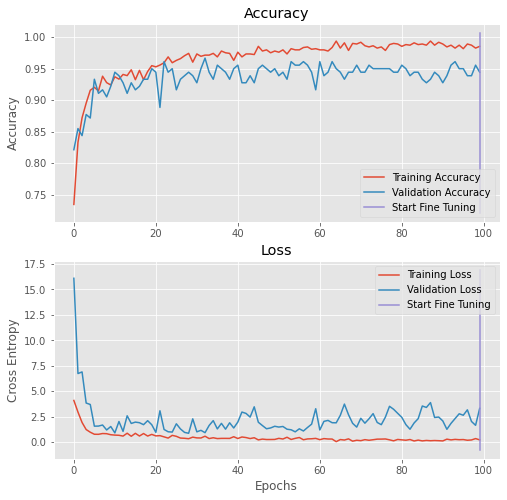

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 5.3442 - accuracy: 0.8828

2/5 [===========>..................] - ETA: 11s - loss: 4.1157 - accuracy: 0.9062

3/5 [=================>............] - ETA: 10s - loss: 2.8219 - accuracy: 0.9323

4/5 [=======================>......] - ETA: 5s - loss: 2.1165 - accuracy: 0.9492 

5/5 [==============================] - ETA: 0s - loss: 2.0104 - accuracy: 0.9518

5/5 [==============================] - 25s 5s/step - loss: 2.0104 - accuracy: 0.9518


[2.0104479789733887, 0.9517624974250793]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

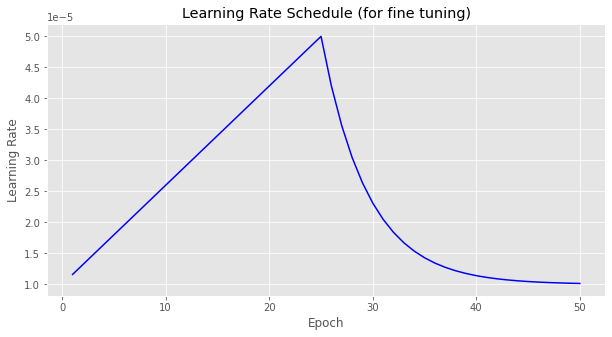

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1077 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 1.0991 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 4s - loss: 0.7362 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 4s - loss: 0.6472 - accuracy: 0.9635

 4/17 [======>.......................] - ETA: 4s - loss: 0.5687 - accuracy: 0.9688

 5/17 [=======>......................] - ETA: 7s - loss: 0.6915 - accuracy: 0.9656

 6/17 [=========>....................] - ETA: 8s - loss: 0.5765 - accuracy: 0.9714

 7/17 [===========>..................] - ETA: 9s - loss: 0.4942 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 10s - loss: 0.4837 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 9s - loss: 0.4299 - accuracy: 0.9792 

10/17 [================>.............] - ETA: 8s - loss: 0.3869 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 8s - loss: 0.3518 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 6s - loss: 0.3343 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 4s - loss: 0.3086 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 3s - loss: 0.3110 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2903 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2875 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9833

17/17 [==============================] - 21s 1s/step - loss: 0.2889 - accuracy: 0.9833 - val_loss: 3.1763 - val_accuracy: 0.9441



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 14s - loss: 0.4889 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 14s - loss: 0.3262 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.3410 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.2730 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.2550 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.2431 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.2181 - accuracy: 0.9861

10/17 [================>.............] - ETA: 12s - loss: 0.2002 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 10s - loss: 0.2310 - accuracy: 0.9815

12/17 [====================>.........] - ETA: 7s - loss: 0.2117 - accuracy: 0.9831 

13/17 [=====================>........] - ETA: 5s - loss: 0.1954 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1815 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1694 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.1510 - accuracy: 0.9879 - val_loss: 3.0326 - val_accuracy: 0.9497



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4239 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 7s - loss: 0.2123 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.1785 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1954 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.1563 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.1306 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1121 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1148 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.1221 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.1661 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.1897 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 6s - loss: 0.1739 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.1606 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1504 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1403 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1316 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.1300 - accuracy: 0.9879 - val_loss: 2.9292 - val_accuracy: 0.9497



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4289 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 6s - loss: 0.4164 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 6s - loss: 0.2779 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 8s - loss: 0.2240 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 12s - loss: 0.3163 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 10s - loss: 0.3719 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.3898 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 14s - loss: 0.3509 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.3119 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.3566 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.3242 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.4128 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.3810 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.3587 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.3576 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.3352 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.3863 - accuracy: 0.9851

17/17 [==============================] - 22s 1s/step - loss: 0.3863 - accuracy: 0.9851 - val_loss: 2.8384 - val_accuracy: 0.9497



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 1.3039e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 6.5193e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 4.9671e-09 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 0.1182 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 15s - loss: 0.1807 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.2622 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.2332 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2061 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 10s - loss: 0.1832 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1649 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 8s - loss: 0.1711 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 7s - loss: 0.2712 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2503 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2796 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2728 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.9833

17/17 [==============================] - 23s 1s/step - loss: 0.2853 - accuracy: 0.9833 - val_loss: 2.7768 - val_accuracy: 0.9497



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0847 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2997 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 16s - loss: 0.2516 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 14s - loss: 0.1887 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 14s - loss: 0.1931 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 16s - loss: 0.3781 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 13s - loss: 0.3993 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 15s - loss: 0.3640 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 13s - loss: 0.3235 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3055 - accuracy: 0.9797

11/17 [==================>...........] - ETA: 9s - loss: 0.2778 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.3114 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2927 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.3051 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.3042 - accuracy: 0.9802

16/17 [===========================>..] - ETA: 1s - loss: 0.2852 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9824

17/17 [==============================] - 23s 1s/step - loss: 0.2711 - accuracy: 0.9824 - val_loss: 2.6528 - val_accuracy: 0.9497



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4283 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 15s - loss: 0.5186 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 14s - loss: 0.3457 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.2760 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.2629 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 15s - loss: 0.2556 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 13s - loss: 0.3057 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 13s - loss: 0.2675 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 11s - loss: 0.2653 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.2477 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 8s - loss: 0.2708 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2685 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2619 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2454 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2403 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2630 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9842

17/17 [==============================] - 24s 1s/step - loss: 0.2501 - accuracy: 0.9842 - val_loss: 2.5449 - val_accuracy: 0.9497



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0529 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0265 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.1299 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1597 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.2330 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2473 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.2277 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.2150 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2798 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2565 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2367 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2203 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2269 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9851

17/17 [==============================] - 24s 1s/step - loss: 0.2144 - accuracy: 0.9851 - val_loss: 2.4715 - val_accuracy: 0.9497



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 2.7567e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 3.5949e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 7s - loss: 0.0209 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 9s - loss: 0.0157 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 14s - loss: 0.0467 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 11s - loss: 0.1721 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.1476 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1813 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1625 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1932 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2035 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2053 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.2216 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2132 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2513 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9861

17/17 [==============================] - 23s 1s/step - loss: 0.2390 - accuracy: 0.9861 - val_loss: 2.4160 - val_accuracy: 0.9497



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4005 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 15s - loss: 0.2069 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 23s - loss: 0.2404 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.1937 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.2410 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.2423 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2560 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.2276 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2284 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.2077 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1904 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1853 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1871 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1746 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1637 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1556 - accuracy: 0.9898 - val_loss: 2.3628 - val_accuracy: 0.9441



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 3.3528e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 17s - loss: 0.2068 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.1553 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1874 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.1809 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.1559 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2156 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.1918 - accuracy: 0.9861

10/17 [================>.............] - ETA: 12s - loss: 0.1966 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.1826 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.1674 - accuracy: 0.9870 

13/17 [=====================>........] - ETA: 5s - loss: 0.2132 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1999 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1865 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1749 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9879

17/17 [==============================] - 24s 1s/step - loss: 0.1663 - accuracy: 0.9879 - val_loss: 2.3136 - val_accuracy: 0.9441



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 30s - loss: 4.3462e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 26s - loss: 2.8975e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 15s - loss: 0.0999 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.0883 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0890 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0871 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1313 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1484 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.1875 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.1964 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.1813 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.1683 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2689 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2521 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9851

17/17 [==============================] - 24s 1s/step - loss: 0.2397 - accuracy: 0.9851 - val_loss: 2.2893 - val_accuracy: 0.9441



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3952 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.2494 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.2630 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 14s - loss: 0.1995 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.1619 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 16s - loss: 0.1410 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 15s - loss: 0.1673 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 12s - loss: 0.1465 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 11s - loss: 0.1302 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.1785 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.1830 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 7s - loss: 0.1691 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1578 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 3s - loss: 0.1465 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1368 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1942 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9842

17/17 [==============================] - 23s 1s/step - loss: 0.1847 - accuracy: 0.9842 - val_loss: 2.2745 - val_accuracy: 0.9441



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0455 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0303 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0881 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.0756 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 16s - loss: 0.2562 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.2483 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.2235 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2451 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2183 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.2027 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.2022 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1973 - accuracy: 0.9898 - val_loss: 2.2612 - val_accuracy: 0.9441



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 1.5235e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 0.2783 - accuracy: 0.9688   

 3/17 [====>.........................] - ETA: 19s - loss: 0.1855 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.1673 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.5418 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 14s - loss: 0.4644 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 13s - loss: 0.4115 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 11s - loss: 0.3658 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.3292 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 8s - loss: 0.3324 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.3127 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2983 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.2770 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2586 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2569 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9842

17/17 [==============================] - 24s 1s/step - loss: 0.2600 - accuracy: 0.9842 - val_loss: 2.2136 - val_accuracy: 0.9441



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1735 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.0868 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0612 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0459 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 20s - loss: 0.0367 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0463 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0405 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 11s - loss: 0.0360 - accuracy: 0.9965

10/17 [================>.............] - ETA: 9s - loss: 0.0324 - accuracy: 0.9969 

11/17 [==================>...........] - ETA: 7s - loss: 0.0295 - accuracy: 0.9972

12/17 [====================>.........] - ETA: 6s - loss: 0.0344 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0455 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0424 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1107 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1092 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.1039 - accuracy: 0.9926 - val_loss: 2.2181 - val_accuracy: 0.9441



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 16s - loss: 0.1061 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0707 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0530 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.2980 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.2483 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.2128 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.1866 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.1659 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1493 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1701 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2135 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2188 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2101 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2574 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2413 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9814

17/17 [==============================] - 24s 1s/step - loss: 0.2605 - accuracy: 0.9814 - val_loss: 2.1923 - val_accuracy: 0.9441



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 1.2636e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.2654 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 25s - loss: 0.2666 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.1999 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.1993 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 17s - loss: 0.1661 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1424 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1255 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1115 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1004 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0912 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0836 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0772 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1017 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0959 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0914 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.0976 - accuracy: 0.9907 - val_loss: 2.1740 - val_accuracy: 0.9441



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7575 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 11s - loss: 0.3982 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.2696 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.2022 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 20s - loss: 0.1618 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 17s - loss: 0.1696 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.2582 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2260 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.2009 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1808 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.1643 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1698 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1568 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1456 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1359 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1520 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1445 - accuracy: 0.9916 - val_loss: 2.1137 - val_accuracy: 0.9441



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 0.2249 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 14s - loss: 0.1687 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.1340 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 12s - loss: 0.1148 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.1009 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 11s - loss: 0.1004 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.1457 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.2335 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2146 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2122 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1970 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1839 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1724 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1640 - accuracy: 0.9916 - val_loss: 2.0864 - val_accuracy: 0.9441



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.1469 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 20s - loss: 0.1423 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.2033 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1743 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1849 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1673 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1509 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1372 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1478 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1365 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1267 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1183 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1589 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.1511 - accuracy: 0.9907 - val_loss: 2.0735 - val_accuracy: 0.9441



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 1.2950 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 7s - loss: 0.7197 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 12s - loss: 0.4803 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 12s - loss: 0.3602 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 13s - loss: 0.2882 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2401 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.2058 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.2151 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.1912 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1909 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1735 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1715 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1877 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1743 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1627 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1525 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1450 - accuracy: 0.9898 - val_loss: 2.0356 - val_accuracy: 0.9441



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0018 - accuracy: 1.0000    

 3/17 [====>.........................] - ETA: 10s - loss: 0.0012 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 0.2627 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.2178 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 18s - loss: 0.3188 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.2737 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.2395 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.2129 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.2336 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2126 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.2937 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.2711 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.3176 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.3065 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2873 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.2732 - accuracy: 0.9916 - val_loss: 2.0143 - val_accuracy: 0.9441



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 2.5146e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 0.2598 - accuracy: 0.9844   

 4/17 [======>.......................] - ETA: 21s - loss: 0.2789 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.3815 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 14s - loss: 0.3339 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 16s - loss: 0.3468 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 15s - loss: 0.3035 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 13s - loss: 0.2960 - accuracy: 0.9792

10/17 [================>.............] - ETA: 11s - loss: 0.2664 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2423 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2339 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2159 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2271 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2120 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.1988 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9861

17/17 [==============================] - 24s 1s/step - loss: 0.1890 - accuracy: 0.9861 - val_loss: 2.0412 - val_accuracy: 0.9441



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0043 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 8s - loss: 0.0058 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 9s - loss: 0.3382 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.3424 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 12s - loss: 0.3778 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 11s - loss: 0.3278 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 12s - loss: 0.3692 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 11s - loss: 0.3473 - accuracy: 0.9774

10/17 [================>.............] - ETA: 10s - loss: 0.3126 - accuracy: 0.9797

11/17 [==================>...........] - ETA: 9s - loss: 0.3001 - accuracy: 0.9787 

12/17 [====================>.........] - ETA: 7s - loss: 0.2784 - accuracy: 0.9792

13/17 [=====================>........] - ETA: 5s - loss: 0.2570 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 3s - loss: 0.2387 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2227 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2261 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9814

17/17 [==============================] - 23s 1s/step - loss: 0.2446 - accuracy: 0.9814 - val_loss: 2.0209 - val_accuracy: 0.9441



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5722 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.2861 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.1908 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.3242 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 19s - loss: 0.3226 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2935 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.2517 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.2202 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1763 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1682 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1872 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1728 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.2826 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.2638 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.2494 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.2371 - accuracy: 0.9916 - val_loss: 1.9859 - val_accuracy: 0.9441



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 5.2928e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 2.6464e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 0.1600 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 9s - loss: 0.1332 - accuracy: 0.9883 

 5/17 [=======>......................] - ETA: 14s - loss: 0.1469 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 11s - loss: 0.1229 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1054 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.1231 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1157 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1580 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1508 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1392 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1294 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1209 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1133 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1078 - accuracy: 0.9907 - val_loss: 1.9861 - val_accuracy: 0.9441



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.0336 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0998 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 15s - loss: 0.0748 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 20s - loss: 0.0599 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.1292 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1130 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1392 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1601 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 7s - loss: 0.1602 - accuracy: 0.9870 

13/17 [=====================>........] - ETA: 5s - loss: 0.1818 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1837 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1714 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1607 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9851

17/17 [==============================] - 24s 1s/step - loss: 0.1705 - accuracy: 0.9851 - val_loss: 2.0001 - val_accuracy: 0.9441



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 1.2655e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 2.8639e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 0.0259 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 17s - loss: 0.2950 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.2360 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2169 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.2188 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1914 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1950 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.2060 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2421 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2048 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.2429 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2267 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.2559 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.2433 - accuracy: 0.9898 - val_loss: 1.9632 - val_accuracy: 0.9441



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1289 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.1979 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 20s - loss: 0.0990 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 21s - loss: 0.0792 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 18s - loss: 0.0660 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.0565 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0495 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9965

10/17 [================>.............] - ETA: 10s - loss: 0.0402 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 9s - loss: 0.0366 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.0335 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0336 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0312 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0291 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0323 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9954

17/17 [==============================] - 24s 1s/step - loss: 0.0307 - accuracy: 0.9954 - val_loss: 1.9379 - val_accuracy: 0.9441



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7205 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 18s - loss: 0.3602 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.3985 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 20s - loss: 0.2989 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.2610 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 17s - loss: 0.2699 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.2313 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.2024 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 14s - loss: 0.2397 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2157 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1961 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 8s - loss: 0.1797 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 6s - loss: 0.1799 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1815 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1694 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1744 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9907

17/17 [==============================] - 25s 1s/step - loss: 0.1659 - accuracy: 0.9907 - val_loss: 1.9700 - val_accuracy: 0.9441



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2451 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.5142 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 22s - loss: 0.3428 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.2635 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.2604 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.2232 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.1953 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1736 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1584 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1482 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1358 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1254 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1164 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1577 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1478 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1440 - accuracy: 0.9926 - val_loss: 1.9675 - val_accuracy: 0.9441



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 18s - loss: 0.2164 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 17s - loss: 0.1731 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1674 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1435 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1345 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.1355 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1546 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1405 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1345 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1671 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1552 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1448 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1358 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1291 - accuracy: 0.9898 - val_loss: 2.0120 - val_accuracy: 0.9441



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.1542 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.1028 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 18s - loss: 0.3540 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.2832 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2360 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.1775 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.2280 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2052 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 10s - loss: 0.1866 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1777 - accuracy: 0.9896 

13/17 [=====================>........] - ETA: 6s - loss: 0.1640 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1523 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1570 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1634 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9898

17/17 [==============================] - 25s 1s/step - loss: 0.1554 - accuracy: 0.9898 - val_loss: 2.0115 - val_accuracy: 0.9441



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 19s - loss: 1.8626e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 0.0306 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 15s - loss: 0.0236 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 17s - loss: 0.0540 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0938 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0821 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0729 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0807 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0673 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0621 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0830 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0774 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0726 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0690 - accuracy: 0.9935 - val_loss: 1.9864 - val_accuracy: 0.9441



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 8.6611e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.1599 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 13s - loss: 0.1599 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.1147 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0983 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0860 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1082 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0974 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 8s - loss: 0.1136 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 7s - loss: 0.1225 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1130 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1050 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1043 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0978 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1017 - accuracy: 0.9916 - val_loss: 1.9979 - val_accuracy: 0.9497



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 1.2050 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 18s - loss: 0.9402 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.7750 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 18s - loss: 0.6481 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 19s - loss: 0.5185 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.4877 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 14s - loss: 0.4210 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 14s - loss: 0.3723 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 12s - loss: 0.3310 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.2979 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2813 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2673 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2469 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2292 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2139 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2111 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9861

17/17 [==============================] - 24s 1s/step - loss: 0.2007 - accuracy: 0.9861 - val_loss: 1.9847 - val_accuracy: 0.9497



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2670 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 23s - loss: 0.2993 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 24s - loss: 0.2944 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2217 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.2915 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.3059 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.2725 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.2839 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.2581 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.2184 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.2028 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.2006 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1880 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.1930 - accuracy: 0.9907 - val_loss: 1.9738 - val_accuracy: 0.9497



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 2.3039e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 4.8392e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 0.0525 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 13s - loss: 0.0394 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0315 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.1209 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.1628 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.1447 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1302 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1184 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1085 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1002 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0930 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0868 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0843 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0802 - accuracy: 0.9935 - val_loss: 1.9367 - val_accuracy: 0.9441



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1176e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.0583 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 17s - loss: 0.0389 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 14s - loss: 0.0292 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 12s - loss: 0.0411 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 11s - loss: 0.0970 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.0831 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0728 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0647 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0585 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0776 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0712 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0682 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0731 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0682 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0640 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.0608 - accuracy: 0.9935 - val_loss: 1.9051 - val_accuracy: 0.9441



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 1.0596 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.6054 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 21s - loss: 0.4036 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.3027 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.2422 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2018 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.1730 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1843 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1638 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1474 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1340 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.1711 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1579 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1837 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1715 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1607 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1546 - accuracy: 0.9926 - val_loss: 1.9131 - val_accuracy: 0.9441



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6665 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.5556 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.3704 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.3658 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.2926 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2438 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.2142 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1874 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1666 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.2138 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2375 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2317 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2139 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2347 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2190 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2347 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9870

17/17 [==============================] - 24s 1s/step - loss: 0.2232 - accuracy: 0.9870 - val_loss: 1.9156 - val_accuracy: 0.9441



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 0.0015 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 14s - loss: 0.1056 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 15s - loss: 0.1156 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 12s - loss: 0.0964 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.0826 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 14s - loss: 0.0766 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.0962 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1022 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0929 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0983 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.2040 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1894 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1768 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.1576 - accuracy: 0.9926 - val_loss: 1.9084 - val_accuracy: 0.9441



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7061 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 19s - loss: 0.3542 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 26s - loss: 0.4697 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 20s - loss: 0.3523 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.3003 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.2503 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.2145 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 16s - loss: 0.2088 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.2048 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1844 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1676 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1711 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1579 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1467 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1369 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1283 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1220 - accuracy: 0.9926 - val_loss: 1.9331 - val_accuracy: 0.9441



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 1.3590e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 6.8101e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 26s - loss: 0.1169 - accuracy: 0.9896    

 4/17 [======>.......................] - ETA: 24s - loss: 0.1202 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.0961 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1878 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1610 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1418 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1260 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1136 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.1033 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 6s - loss: 0.0947 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0874 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1133 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1265 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1186 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1379 - accuracy: 0.9926 - val_loss: 1.9178 - val_accuracy: 0.9441



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5849 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 5s - loss: 0.2924 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 11s - loss: 0.1950 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.1484 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.1187 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0989 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0848 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0742 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 10s - loss: 0.0660 - accuracy: 0.9965

10/17 [================>.............] - ETA: 9s - loss: 0.0594 - accuracy: 0.9969 

11/17 [==================>...........] - ETA: 7s - loss: 0.0676 - accuracy: 0.9943

12/17 [====================>.........] - ETA: 6s - loss: 0.0802 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0740 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0687 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0920 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1298 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1833 - accuracy: 0.9907 - val_loss: 1.8705 - val_accuracy: 0.9497



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0353 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0177 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 19s - loss: 0.0844 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.2006 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.1605 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 17s - loss: 0.1552 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.2017 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1765 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1658 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1492 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1356 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1243 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1150 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1068 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0997 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1038 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9935

17/17 [==============================] - 24s 1s/step - loss: 0.0987 - accuracy: 0.9935 - val_loss: 1.8527 - val_accuracy: 0.9497



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7523 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.4776 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 7s - loss: 0.3185 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 18s - loss: 0.2397 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.3137 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.2738 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 11s - loss: 0.2424 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 11s - loss: 0.2121 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 9s - loss: 0.1885 - accuracy: 0.9896 

10/17 [================>.............] - ETA: 9s - loss: 0.1697 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 7s - loss: 0.1724 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1581 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1472 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1608 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1501 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1408 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9916

17/17 [==============================] - 22s 1s/step - loss: 0.1338 - accuracy: 0.9916 - val_loss: 1.8558 - val_accuracy: 0.9497



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2119 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.2384 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 20s - loss: 0.1589 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1192 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.1299 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.1100 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0845 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.0751 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.0676 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.0646 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 7s - loss: 0.0592 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0547 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0617 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0576 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0921 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.0882 - accuracy: 0.9907 - val_loss: 1.8952 - val_accuracy: 0.9497



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 14s - loss: 0.0000e+00 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 13s - loss: 0.0826 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 17s - loss: 0.0800 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.1070 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.1212 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 10s - loss: 0.1077 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0970 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 7s - loss: 0.0881 - accuracy: 0.9943

12/17 [====================>.........] - ETA: 6s - loss: 0.0808 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 4s - loss: 0.0746 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.0719 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0671 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9944

17/17 [==============================] - 23s 1s/step - loss: 0.0957 - accuracy: 0.9944 - val_loss: 1.9278 - val_accuracy: 0.9497


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

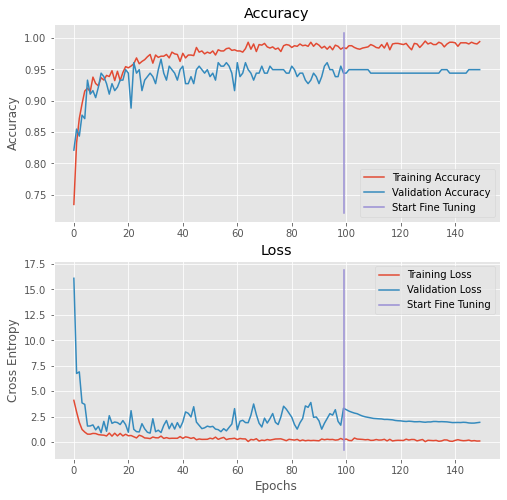

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.4758 - accuracy: 0.9141

2/5 [===========>..................] - ETA: 2s - loss: 1.8527 - accuracy: 0.9336

3/5 [=================>............] - ETA: 2s - loss: 1.2895 - accuracy: 0.9531

4/5 [=======================>......] - ETA: 1s - loss: 1.0030 - accuracy: 0.9629

5/5 [==============================] - ETA: 0s - loss: 0.9528 - accuracy: 0.9647

5/5 [==============================] - 6s 1s/step - loss: 0.9528 - accuracy: 0.9647


[0.9527931213378906, 0.9647495150566101]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9647495361781077
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       158
           1       0.96      0.99      0.98       381

    accuracy                           0.96       539
   macro avg       0.97      0.95      0.96       539
weighted avg       0.96      0.96      0.96       539



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

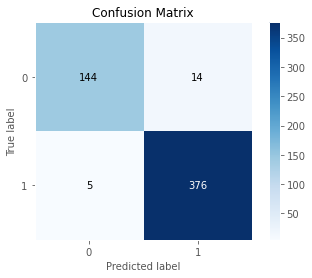

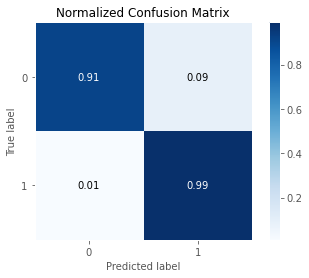

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

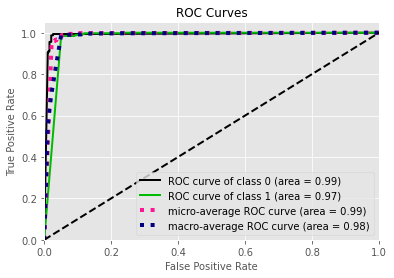

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       158
           1       0.96      0.99      0.98       381

    accuracy                           0.96       539
   macro avg       0.97      0.95      0.96       539
weighted avg       0.96      0.96      0.96       539

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.91      0.99      0.94      0.95      0.89       158
          1       0.96      0.99      0.91      0.98      0.95      0.91       381

avg / total       0.96      0.96      0.93      0.96      0.95      0.90       539

